<a href="https://colab.research.google.com/github/OHikaru/Shirakawa/blob/main/Shirakawa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =========================================
# 1. 必要なライブラリのインストール・インポート
# =========================================

# Google Colab では statsmodels が標準で入っていますが、無い場合は以下コマンドを実行
# !pip install statsmodels

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols, logit

# =========================================
# 2. データの読み込み
# =========================================
# CSVファイルのパスを指定しています（ユーザ指定のパス）
file_path = "/content/drive/MyDrive/dataset/Shirakawa.csv"
df = pd.read_csv(file_path)

# どのような列があるか先頭数行をチェック
print("==== Head of DataFrame ====")
print(df.head())

# =========================================
# 3. 列名のリネーム (任意だが可読性向上のため)
#    ※ 変数名に合わせてリネーム
# =========================================
df = df.rename(columns={
    "Suture_Quill1Vloc2Vicryl3": "SutureType",
    "VaginalDisconnectDelay_yes1no0": "Disconnect",
    "NumberOfStitches": "Stitches",
    "Operator_Advanced1Mid2Young3": "Operator",
    "SutureTime": "Time"
})

# =========================================
# 4. Barbed Suture かどうかを示す変数の追加
#    Quill(1) or V-loc(2) = Barbed → 1
#    Vicryl(3)           = Non-Barbed → 0
# =========================================
df["Barbed"] = df["SutureType"].apply(lambda x: 1 if x in [1, 2] else 0)

# =========================================
# 5. データの基本統計量・カテゴリの確認
# =========================================
print("\n==== Basic Statistics ====")
print(df.describe(include="all"))

print("\n==== Value Counts ====")
print("SutureType:\n", df["SutureType"].value_counts())
print("Disconnect:\n", df["Disconnect"].value_counts())
print("Operator:\n", df["Operator"].value_counts())
print("Barbed:\n", df["Barbed"].value_counts())

# =========================================
# 6. 縫合時間(Time)に関する解析（線形回帰の例）
#    Barbed (0/1) や Operator(1,2,3) などを説明変数とする
#    Operator はカテゴリ変数として扱うため C() を使用
# =========================================

model_lm = ols("Time ~ Barbed + C(Operator) + Stitches", data=df).fit()
print("\n==== [線形回帰] 縫合時間に関する結果 ====")
print(model_lm.summary())

# =========================================
# 7. 離開(Disconnect)に関する解析（ロジスティック回帰の例）
#    離開の有無を目的変数とし、Barbed, Operator, Stitches, Timeを説明変数にする
#    Operator はカテゴリ変数として扱うため C() を使用
# =========================================

# ロジスティック回帰
model_logit = logit("Disconnect ~ Barbed + C(Operator) + Stitches + Time", data=df).fit()
print("\n==== [ロジスティック回帰] 離開(Disconnect)に関する結果 ====")
print(model_logit.summary())

# =========================================
# 8. 交互作用を考慮したい場合の例
#    若手(Operator=3) × Barbed などの交互作用項を試す場合
# =========================================

# 例: Disconnect ~ Barbed * C(Operator) + Stitches + Time
#    => バーブド糸と術者レベルの組み合わせの効果を評価
model_logit_interact = logit("Disconnect ~ Barbed * C(Operator) + Stitches + Time", data=df).fit()
print("\n==== [ロジスティック回帰 with 交互作用] 離開(Disconnect)に関する結果 ====")
print(model_logit_interact.summary())

# =========================================
# 9. 結果の解釈
# =========================================
# - 線形回帰 (Time ~ ...) の回帰係数から、Barbed=1 のとき縫合時間がどう変化するかを確認
# - ロジスティック回帰 (Disconnect ~ ...) のオッズ比を算出したい場合は、
#   np.exp(model_logit.params) などで係数の指数を取る

print("\n==== ロジスティック回帰パラメータのオッズ比 ====")
print(np.exp(model_logit.params))

==== Head of DataFrame ====
   Suture_Quill1Vloc2Vicryl3  VaginalDisconnectDelay_yes1no0  \
0                          1                               0   
1                          1                               0   
2                          1                               0   
3                          1                               0   
4                          1                               0   

   NumberOfStitches  Operator_Advanced1Mid2Young3  SutureTime  
0                 8                             1        8.00  
1                 4                             1        8.75  
2                 8                             2       17.00  
3                 5                             2        6.00  
4                 7                             2        8.00  

==== Basic Statistics ====
       SutureType  Disconnect    Stitches    Operator        Time      Barbed
count  224.000000  224.000000  224.000000  224.000000  224.000000  224.000000
mean     2.205357  

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<ipython-input-4-e61d2cfae3d0>:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
<ipython-input-4-e61d2cfae3d0>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-4-e61d2cfae3d0>:9: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(


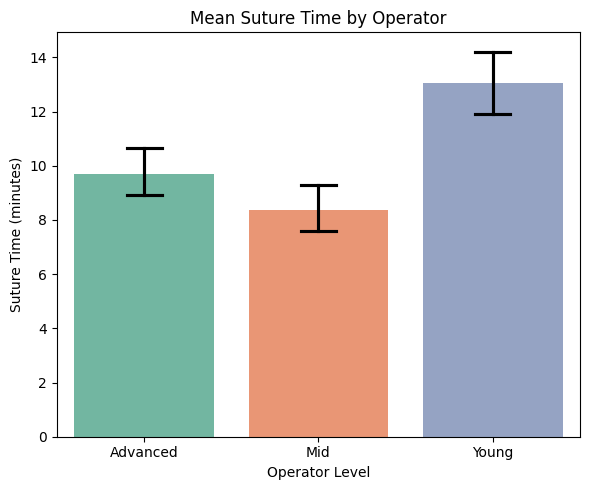

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# まず、Operator=1/2/3 を文字ラベルにしておくとグラフで読みやすい
df["OperatorLabel"] = df["Operator"].map({1: "Advanced", 2: "Mid", 3: "Young"})

# 単純に Operator ごとに平均縫合時間を棒グラフで表示
plt.figure(figsize=(6, 5))
sns.barplot(
    data=df,
    x="OperatorLabel",
    y="Time",
    ci=95,           # 95%信頼区間
    capsize=0.2,     # エラーバーの先端にキャップをつける
    errcolor="black",
    palette="Set2"
)

plt.title("Mean Suture Time by Operator")
plt.xlabel("Operator Level")
plt.ylabel("Suture Time (minutes)")
plt.tight_layout()
plt.show()

<ipython-input-3-b8af8841405c>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
<ipython-input-3-b8af8841405c>:10: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(


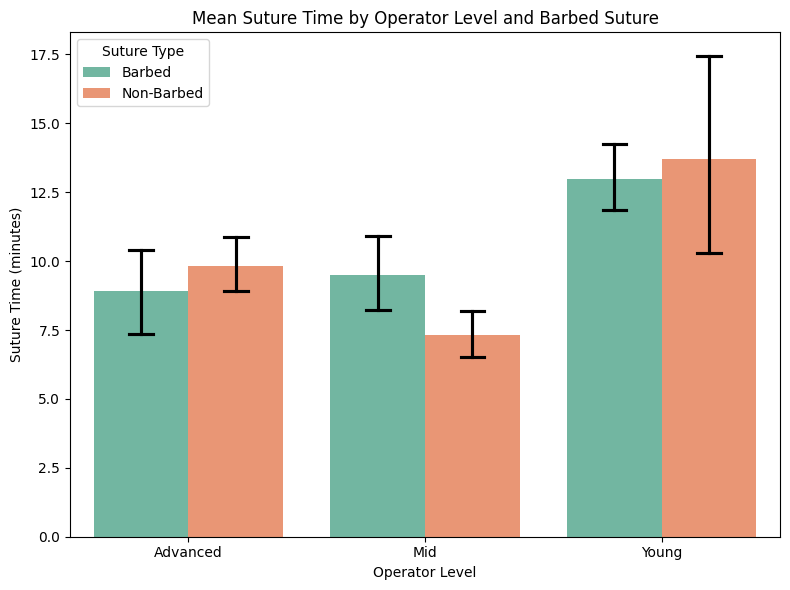

<ipython-input-3-b8af8841405c>:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
<ipython-input-3-b8af8841405c>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-3-b8af8841405c>:29: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(


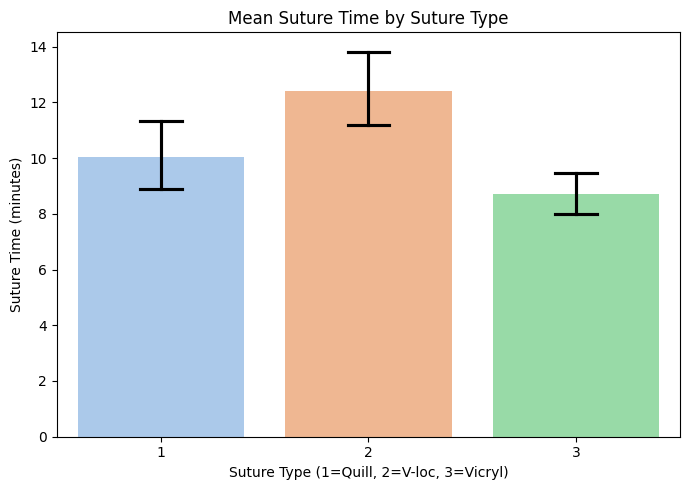

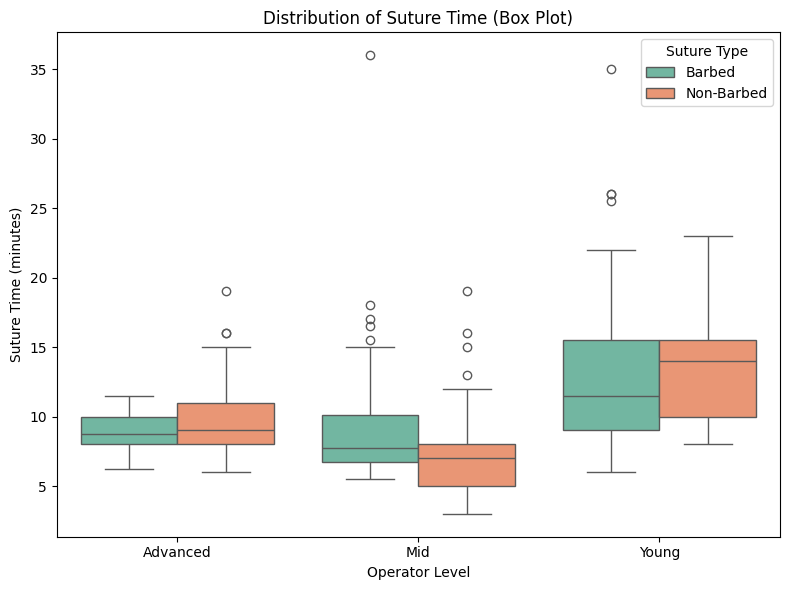

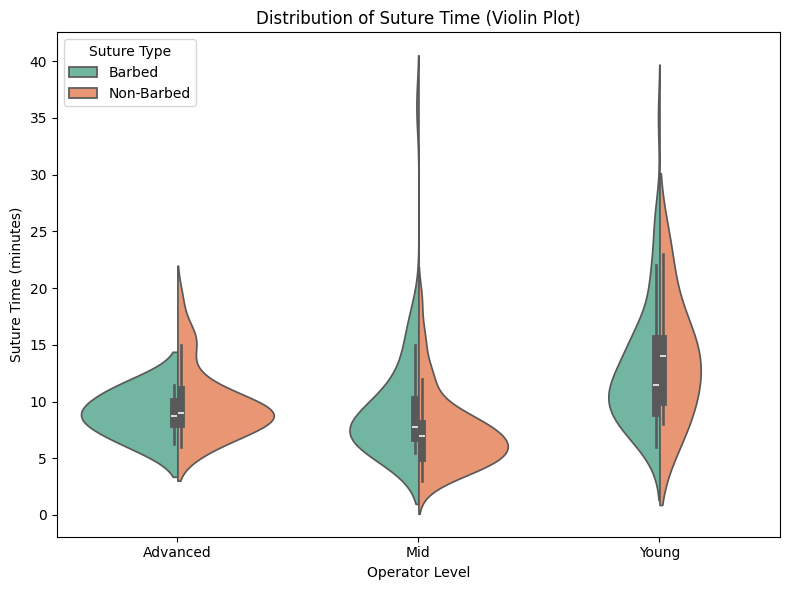

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create new columns for better readability in English
df["SutureLabel"] = df["Barbed"].map({1: "Barbed", 0: "Non-Barbed"})
df["OperatorLabel"] = df["Operator"].map({1: "Advanced", 2: "Mid", 3: "Young"})

# 1. Bar plot: Mean suture time by operator level and barbed status
plt.figure(figsize=(8, 6))
sns.barplot(
    data=df,
    x="OperatorLabel",
    y="Time",
    hue="SutureLabel",
    ci=95,            # 95% confidence interval
    capsize=0.2,
    errcolor="black",
    palette="Set2"
)
plt.title("Mean Suture Time by Operator Level and Barbed Suture")
plt.xlabel("Operator Level")
plt.ylabel("Suture Time (minutes)")
plt.legend(title="Suture Type", loc="best")
plt.tight_layout()
plt.show()

# 2. Bar plot: Mean suture time by suture type (Quill=1, V-loc=2, Vicryl=3)
plt.figure(figsize=(7, 5))
sns.barplot(
    data=df,
    x="SutureType",
    y="Time",
    ci=95,
    capsize=0.2,
    errcolor="black",
    palette="pastel"
)
plt.title("Mean Suture Time by Suture Type")
plt.xlabel("Suture Type (1=Quill, 2=V-loc, 3=Vicryl)")
plt.ylabel("Suture Time (minutes)")
plt.tight_layout()
plt.show()

# 3. Box plot: Distribution of suture time by operator level and barbed status
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df,
    x="OperatorLabel",
    y="Time",
    hue="SutureLabel",
    palette="Set2"
)
plt.title("Distribution of Suture Time (Box Plot)")
plt.xlabel("Operator Level")
plt.ylabel("Suture Time (minutes)")
plt.legend(title="Suture Type", loc="best")
plt.tight_layout()
plt.show()

# 4. Violin plot: Distribution of suture time by operator level and barbed status
plt.figure(figsize=(8, 6))
sns.violinplot(
    data=df,
    x="OperatorLabel",
    y="Time",
    hue="SutureLabel",
    split=True,
    palette="Set2"
)
plt.title("Distribution of Suture Time (Violin Plot)")
plt.xlabel("Operator Level")
plt.ylabel("Suture Time (minutes)")
plt.legend(title="Suture Type", loc="best")
plt.tight_layout()
plt.show()

<ipython-input-5-e61d2cfae3d0>:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
<ipython-input-5-e61d2cfae3d0>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-5-e61d2cfae3d0>:9: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(


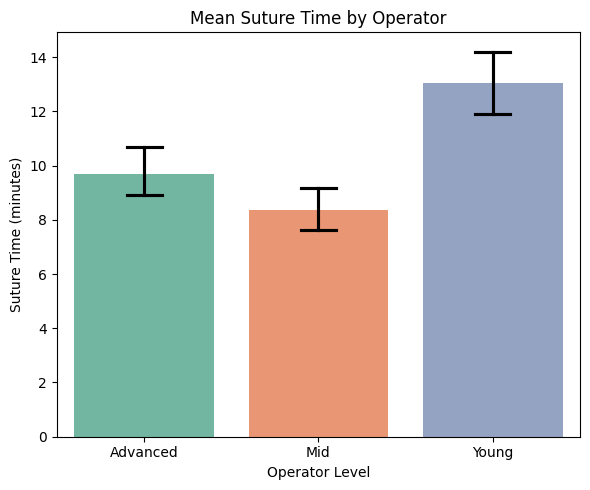

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# まず、Operator=1/2/3 を文字ラベルにしておくとグラフで読みやすい
df["OperatorLabel"] = df["Operator"].map({1: "Advanced", 2: "Mid", 3: "Young"})

# 単純に Operator ごとに平均縫合時間を棒グラフで表示
plt.figure(figsize=(6, 5))
sns.barplot(
    data=df,
    x="OperatorLabel",
    y="Time",
    ci=95,           # 95%信頼区間
    capsize=0.2,     # エラーバーの先端にキャップをつける
    errcolor="black",
    palette="Set2"
)

plt.title("Mean Suture Time by Operator")
plt.xlabel("Operator Level")
plt.ylabel("Suture Time (minutes)")
plt.tight_layout()
plt.show()

In [6]:
# =========================================
# 1. 必要なライブラリのインストール・インポート
# =========================================

# Google Colab では statsmodels が標準で入っていますが、無い場合は以下コマンドを実行
# !pip install statsmodels

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols, logit

# =========================================
# 2. データの読み込み
# =========================================
# CSVファイルのパスを指定しています（ユーザ指定のパス）
file_path = "/content/drive/MyDrive/dataset/Shirakawa.csv"
df = pd.read_csv(file_path)

# どのような列があるか先頭数行をチェック
print("==== Head of DataFrame ====")
print(df.head())

# =========================================
# 3. 列名のリネーム (任意だが可読性向上のため)
#    ※ 変数名に合わせてリネーム
# =========================================
df = df.rename(columns={
    "Suture_Quill1Vloc2Vicryl3": "SutureType",
    "VaginalDisconnectDelay_yes1no0": "Disconnect",
    "NumberOfStitches": "Stitches",
    "Operator_Advanced1Mid2Young3": "Operator",
    "SutureTime": "Time"
})

# =========================================
# 4. Barbed 列は作成せず、SutureType(1,2,3)をそのまま使用
#    Quill(1), V-loc(2), Vicryl(3) を区別する
# =========================================
# df["Barbed"] = df["SutureType"].apply(lambda x: 1 if x in [1, 2] else 0)  # ← 削除/コメントアウト

# =========================================
# 5. データの基本統計量・カテゴリの確認
# =========================================
print("\n==== Basic Statistics ====")
print(df.describe(include="all"))

print("\n==== Value Counts ====")
print("SutureType:\n", df["SutureType"].value_counts())
print("Disconnect:\n", df["Disconnect"].value_counts())
print("Operator:\n", df["Operator"].value_counts())

# =========================================
# 6. 縫合時間(Time)に関する解析（線形回帰の例）
#    SutureType をカテゴリ変数 (C(SutureType)) として利用
#    Operator もカテゴリ変数として扱うため C() を使用
# =========================================

# 例: Time ~ C(SutureType) + C(Operator) + Stitches
model_lm = ols("Time ~ C(SutureType) + C(Operator) + Stitches", data=df).fit()
print("\n==== [線形回帰] 縫合時間に関する結果 ====")
print(model_lm.summary())

# =========================================
# 7. 離開(Disconnect)に関する解析（ロジスティック回帰の例）
#    離開の有無を目的変数とし、SutureType, Operator, Stitches, Timeを説明変数にする
#    Operator, SutureType はカテゴリ変数として扱う
# =========================================

# ロジスティック回帰
model_logit = logit("Disconnect ~ C(SutureType) + C(Operator) + Stitches + Time", data=df).fit()
print("\n==== [ロジスティック回帰] 離開(Disconnect)に関する結果 ====")
print(model_logit.summary())

# =========================================
# 8. 交互作用を考慮したい場合の例
#    若手(Operator=3) × SutureType などの交互作用項を試す場合
# =========================================

# 例: Disconnect ~ C(SutureType) * C(Operator) + Stitches + Time
#    => 縫合糸の種類と術者レベルの組み合わせ効果を評価
model_logit_interact = logit(
    "Disconnect ~ C(SutureType) * C(Operator) + Stitches + Time",
    data=df
).fit()
print("\n==== [ロジスティック回帰 with 交互作用] 離開(Disconnect)に関する結果 ====")
print(model_logit_interact.summary())

# =========================================
# 9. 結果の解釈
# =========================================
# - 線形回帰 (Time ~ ...) の回帰係数から、Quill, V-loc, Vicryl それぞれが
#   縫合時間にどう影響するかを比較
# - ロジスティック回帰 (Disconnect ~ ...) のオッズ比を算出したい場合は、
#   np.exp(model_logit.params) などで係数の指数を取る

print("\n==== ロジスティック回帰パラメータのオッズ比 ====")
print(np.exp(model_logit.params))

==== Head of DataFrame ====
   Suture_Quill1Vloc2Vicryl3  VaginalDisconnectDelay_yes1no0  \
0                          1                               0   
1                          1                               0   
2                          1                               0   
3                          1                               0   
4                          1                               0   

   NumberOfStitches  Operator_Advanced1Mid2Young3  SutureTime  
0                 8                             1        8.00  
1                 4                             1        8.75  
2                 8                             2       17.00  
3                 5                             2        6.00  
4                 7                             2        8.00  

==== Basic Statistics ====
       SutureType  Disconnect    Stitches    Operator        Time
count  224.000000  224.000000  224.000000  224.000000  224.000000
mean     2.205357    0.196429    6.250000  

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [1]:
# =========================================
# 1. 必要なライブラリのインストール・インポート
# =========================================
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols, logit
from statsmodels.stats.anova import anova_lm  # ANOVA表を出す際に使用

# =========================================
# 2. データの読み込み
# =========================================
file_path = "/content/drive/MyDrive/dataset/Shirakawa.csv"
df = pd.read_csv(file_path)

# 確認用
print("==== Head of DataFrame ====")
print(df.head())

# =========================================
# 3. 列名のリネーム
# =========================================
df = df.rename(columns={
    "Suture_Quill1Vloc2Vicryl3": "SutureType",
    "VaginalDisconnectDelay_yes1no0": "Disconnect",
    "NumberOfStitches": "Stitches",
    "Operator_Advanced1Mid2Young3": "Operator",
    "SutureTime": "Time"
})

# =========================================
# 4. Barbed Suture かどうかを示す変数を作成
#    Quill(1) or V-loc(2) = Barbed → 1
#    Vicryl(3)           = Non-Barbed → 0
# =========================================
df["Barbed"] = df["SutureType"].apply(lambda x: 1 if x in [1, 2] else 0)

# =========================================
# 5. Barbed 群 / Non-Barbed 群に層別化
# =========================================
df_barbed = df[df["Barbed"] == 1].copy()
df_nonbarbed = df[df["Barbed"] == 0].copy()

print("\n--- Counts ---")
print("All samples:", len(df))
print("Barbed:", len(df_barbed))
print("Non-Barbed:", len(df_nonbarbed))

# =========================================
# 6. Barbed 群における術者レベル(Operator)別の縫合時間の有無を検討
#    (a) シンプルな ANOVA: Time ~ C(Operator)
# =========================================
model_lm_barbed_simple = ols("Time ~ C(Operator)", data=df_barbed).fit()
anova_barbed_simple = anova_lm(model_lm_barbed_simple, typ=2)
print("\n==== [Barbed群] ANOVA (Time ~ C(Operator)) ====")
print(anova_barbed_simple)
print(model_lm_barbed_simple.summary())

# (b) 共変量に針数(Stitches)を加えて調整したモデル
model_lm_barbed_adj = ols("Time ~ C(Operator) + Stitches", data=df_barbed).fit()
anova_barbed_adj = anova_lm(model_lm_barbed_adj, typ=2)
print("\n==== [Barbed群] ANOVA (Time ~ C(Operator) + Stitches) ====")
print(anova_barbed_adj)
print(model_lm_barbed_adj.summary())

# =========================================
# 7. Non-Barbed 群における術者レベル(Operator)別の縫合時間の有無を検討
#    (a) シンプルな ANOVA: Time ~ C(Operator)
# =========================================
model_lm_nonbarbed_simple = ols("Time ~ C(Operator)", data=df_nonbarbed).fit()
anova_nonbarbed_simple = anova_lm(model_lm_nonbarbed_simple, typ=2)
print("\n==== [Non-Barbed群] ANOVA (Time ~ C(Operator)) ====")
print(anova_nonbarbed_simple)
print(model_lm_nonbarbed_simple.summary())

# (b) 共変量に針数(Stitches)を加えて調整したモデル
model_lm_nonbarbed_adj = ols("Time ~ C(Operator) + Stitches", data=df_nonbarbed).fit()
anova_nonbarbed_adj = anova_lm(model_lm_nonbarbed_adj, typ=2)
print("\n==== [Non-Barbed群] ANOVA (Time ~ C(Operator) + Stitches) ====")
print(anova_nonbarbed_adj)
print(model_lm_nonbarbed_adj.summary())

==== Head of DataFrame ====
   Suture_Quill1Vloc2Vicryl3  VaginalDisconnectDelay_yes1no0  \
0                          1                               0   
1                          1                               0   
2                          1                               0   
3                          1                               0   
4                          1                               0   

   NumberOfStitches  Operator_Advanced1Mid2Young3  SutureTime  
0                 8                             1        8.00  
1                 4                             1        8.75  
2                 8                             2       17.00  
3                 5                             2        6.00  
4                 7                             2        8.00  

--- Counts ---
All samples: 224
Barbed: 125
Non-Barbed: 99

==== [Barbed群] ANOVA (Time ~ C(Operator)) ====
                  sum_sq     df         F    PR(>F)
C(Operator)   387.544873    2.0  7.188733  